In [1]:
import numpy as np
import tensorflow as tf
import scipy.io
import tensorly as ts
import os
import matplotlib.pyplot as plt
os.chdir("G:/jupyter/Guangzhou-data-set")
tensor = scipy.io.loadmat('tensor.mat')
tensor = tensor['tensor']
tensor = np.array(tensor)
print(tensor.shape)
tensor = tensor.reshape(214,-1)
print(tensor.shape)
tensor[tensor<=0]=(np.sum(tensor)*1.0/(tensor.shape[0]*tensor.shape[1]))

Using numpy backend.


(214, 61, 144)
(214, 8784)


In [2]:
tensor_1 = tensor[:,:8784-144*5]

missing_rate = 0.
condition = np.random.binomial(1, 1-missing_rate, np.shape(tensor_1)[0]*np.shape(tensor_1)[1])
condition = np.reshape(condition,(np.shape(tensor_1)[0],np.shape(tensor_1)[1]))
mask = np.where(condition<1,0.,1.)

print(mask.shape)
sparse_tensor1 = np.multiply(tensor_1, mask)

print(sparse_tensor1.shape)

mean = (np.sum(sparse_tensor1)*1.0/np.sum(mask))
init_tensor = sparse_tensor1
init_tensor[init_tensor==0] = mean
print(init_tensor.shape)

(214, 8064)
(214, 8064)
(214, 8064)


In [3]:
input_horizon = 3
pred_horizon = 6
network_size = 214
sampleset = []
field_predict_set=[]
lastspeedset=[]
for i in range(tensor_1.shape[1]-input_horizon-pred_horizon):
    sample = []
    field_predict = []
    for r in range(network_size):
        sample+=tensor_1[r,i:i+input_horizon].tolist()[:]
    for r in range(network_size):
        sample+=tensor_1[r,i+input_horizon:i+input_horizon+pred_horizon].tolist()[:]
    sampleset.append(sample)
    field_predict_set.append(tensor_1[:,i+input_horizon:i+input_horizon+pred_horizon].reshape(network_size*pred_horizon))
    lastspeedset.append(tensor_1[:,i+input_horizon-1].tolist()[:])
print('Sample num: %d'%len(sampleset))

def generateBatch(samples,fieldset,epoch,lastspeedset,input_horizon=input_horizon,feature_len=network_size,batchsize=32, istrain=True):
    xbatchset=[]
    ybatchset=[]
    lastspeedbatchset=[]
    for i in range(batchsize):
        if istrain:
            index = epoch*batchsize+i
            xbatchset.append(samples[index][:input_horizon*feature_len])
            ybatchset.append(samples[index][input_horizon*feature_len:])
            lastspeedbatchset.append(lastspeedset[index][:])
            
    return xbatchset,ybatchset,lastspeedbatchset

Sample num: 8055


## predict with fixed history speed

In [7]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.02, shape=shape)
    return initial

class Model():
    def __init__(self,input_horizon, predict_horizon, networksize, feature_len):
        self.input_horizon = networksize
        self.predict_horizon = predict_horizon
        self.networksize = networksize
        self.feature_len = input_horizon
        self.bottom = tf.placeholder(tf.float32, shape=[None, self.input_horizon*self.feature_len], name='input')  
        self.target = tf.placeholder(tf.float32, shape=[None, self.predict_horizon*self.networksize], name='target')
        self.lastspeed = tf.placeholder(tf.float32, shape=[None, self.networksize], name='history') 
        
    def build_TF(self,num_layers=1,batch_size=16,rnn_size=128): # rnn_size : output_size
        self.bottom1 = tf.reshape(self.bottom, [-1, self.feature_len])
        bottom = tf.reshape(self.bottom, [-1, self.feature_len])
        
        feat_dim=256
        W_q = weight_variable([self.feature_len, feat_dim])
        b_q = bias_variable([feat_dim])
        
        self.Q = tf.nn.elu(tf.matmul(bottom,W_q))+b_q
        
        W_k = weight_variable([self.feature_len, feat_dim])
        b_k = bias_variable([feat_dim])
        self.K = tf.nn.elu(tf.matmul(bottom,W_k))+b_k
                           
        W_v = weight_variable([self.feature_len, self.predict_horizon])
        b_v = bias_variable([self.predict_horizon])
        self.V = tf.nn.elu(tf.matmul(bottom,W_v))+b_v
        
        self.K = tf.reshape(self.K,(-1,self.networksize,feat_dim))
        self.K = tf.transpose(self.K,(0,2,1))
        self.Q = tf.reshape(self.Q,(-1,self.networksize,feat_dim))
        
    
        self.attention_ = tf.matmul(self.Q,self.K)/tf.sqrt(feat_dim*1.)
        
        self.attention = tf.nn.softmax( self.attention_ )
        
        self.V = tf.reshape(self.V,(-1,self.networksize,self.predict_horizon))
        
        temp = tf.reshape(self.lastspeed,(-1,1))
        self.history = tf.concat([temp,temp],1)
        for t in range(self.predict_horizon-2):
            self.history = tf.concat([self.history,temp],1)
        self.history = tf.reshape(self.history,(-1,self.networksize*self.predict_horizon))
        
        self.varaiation= tf.reshape(tf.matmul(self.attention,self.V),(-1,self.networksize*self.predict_horizon))#+self.lastspeed      
        
        self.predict = self.varaiation+self.history
        self.loss_his = tf.reduce_mean(tf.squared_difference(self.target, self.history))
        self.loss = tf.reduce_mean(tf.squared_difference(self.target, self.predict))
        self.accuracy = 1. - tf.reduce_mean(abs(self.target-self.predict)/self.target)
        self.learning_rate = 0.002
        
        self.trainop = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        
        

In [8]:
tf.reset_default_graph()
sess = tf.Session()

model = Model(input_horizon=input_horizon, predict_horizon=pred_horizon, networksize=network_size,feature_len=network_size)
model.build_TF()

# parameter initialization
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init_op)
saver = tf.train.Saver()

In [9]:
end = 8748-144*5
trainset = sampleset[0:end]
train_field_predict_set = field_predict_set[0:end]

testset = sampleset[end:]
test_field_predict_set = field_predict_set[end:]

train_epochs = 6
batch_size = 16

for epoch in range(train_epochs):
    eploss = []
    train_field_loss = []
    for ep in range(int(len(trainset)/(batch_size+1))):
        x_batch, y_batch, lastspeed_batch = generateBatch(trainset,train_field_predict_set,lastspeedset=lastspeedset[0:end],batchsize=batch_size, epoch=ep)

        _, loss_, acc_train = sess.run([model.trainop, model.loss, model.accuracy],
                                       feed_dict={model.bottom: x_batch, model.target: y_batch,model.lastspeed:lastspeed_batch})
        
        eploss.append(loss_)

        
    x_batch, y_batch,lastspeed_batch = generateBatch(testset, test_field_predict_set,lastspeedset=lastspeedset[end:], batchsize=len(testset)-1, epoch=0)
    
    loss_, acc_train,loss_his = sess.run([model.loss, model.accuracy,model.loss_his ],
                                       feed_dict={model.bottom: x_batch, model.target: y_batch,model.lastspeed:lastspeed_batch})
    
    print('Epoch:%d==> Train loss: %g | Test field loss:%g |hisloss:%g'%(epoch,np.sqrt(float(sum(eploss)/len(eploss))),np.sqrt(loss_),np.sqrt(loss_his)))
    
save_path = saver.save(sess, "G:/jupyter/tmp3/model.ckpt")
    

Epoch:0==> Train loss: 5.11542 | Test field loss:4.48493 |hisloss:4.47354
Epoch:1==> Train loss: 5.03931 | Test field loss:4.28648 |hisloss:4.47354
Epoch:2==> Train loss: 4.91209 | Test field loss:4.17481 |hisloss:4.47354
Epoch:3==> Train loss: 4.86156 | Test field loss:4.1264 |hisloss:4.47354
Epoch:4==> Train loss: 4.83595 | Test field loss:4.11853 |hisloss:4.47354
Epoch:5==> Train loss: 4.82563 | Test field loss:4.11771 |hisloss:4.47354


In [10]:
# definnition for validation
tensor_2 = tensor[:,-144*5:]
dim = tensor_2.shape

pred_result_set=[]
field_set = []
loss_set=[]
mf_loss_set=[]
hisresult=[]
variation_set=[]
for t in range(144*5-input_horizon):   
    tf.reset_default_graph()
    sess = tf.Session()
    model = Model(input_horizon=input_horizon, predict_horizon=pred_horizon, networksize=network_size,feature_len=network_size)
    model.build_TF()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    if 1:
        saver.restore(sess, "G:/jupyter/tmp3/model.ckpt")

    # feature prediction & speed prediction
    field=tensor_2[:,t+input_horizon:t+input_horizon+pred_horizon]
    field = np.array(field).reshape(-1,network_size*pred_horizon)
    
    field_loss_,pred_result,lastspeed,variation = sess.run([model.loss, model.predict,model.history,model.varaiation],feed_dict={model.bottom:tensor_2[:,t:t+input_horizon].reshape(1,-1),model.lastspeed:tensor_2[:,t+input_horizon-1].reshape(1,-1),model.target:tensor_2[:,t+input_horizon:t+input_horizon+pred_horizon].reshape(1,-1)})

    print('##Epoch %d field loss %g'%(t, np.sqrt(field_loss_)))
    print('-------------------------------------------------')
    pred_result_set.append(pred_result[0])
    hisresult.append(lastspeed[0])
    field_set.append(field[0])
    loss_set.append(np.sqrt(field_loss_))
    variation_set.append(variation[0])
#     mf_loss_set.append(np.sqrt(loss_valid_))

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 0 field loss 2.54359
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 1 field loss 2.45784
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 2 field loss 2.54931
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 3 field loss 2.4005
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 4 field loss 2.42904
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 5 field loss 2.77226
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 6 field loss 2.86655
---------------

##Epoch 55 field loss 6.09599
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 56 field loss 5.8476
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 57 field loss 5.93857
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 58 field loss 5.72228
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 59 field loss 5.52125
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 60 field loss 5.48107
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 61 field loss 5.6204
-------------------------------------------------
INFO:tensorflow:Restoring pa

##Epoch 110 field loss 6.98061
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 111 field loss 6.74864
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 112 field loss 6.53902
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 113 field loss 6.23565
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 114 field loss 6.12954
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 115 field loss 5.37893
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 116 field loss 4.63439
-------------------------------------------------
INFO:tensorflow:Res

##Epoch 165 field loss 6.54034
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 166 field loss 6.74282
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 167 field loss 6.789
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 168 field loss 6.87557
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 169 field loss 6.76043
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 170 field loss 6.88155
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 171 field loss 14.3426
-------------------------------------------------
INFO:tensorflow:Resto

##Epoch 220 field loss 4.25282
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 221 field loss 4.7499
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 222 field loss 5.79723
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 223 field loss 5.3927
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 224 field loss 5.57293
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 225 field loss 5.99462
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 226 field loss 6.0795
-------------------------------------------------
INFO:tensorflow:Restor

##Epoch 275 field loss 4.38436
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 276 field loss 3.9323
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 277 field loss 4.2145
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 278 field loss 3.57702
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 279 field loss 2.42902
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 280 field loss 2.83515
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 281 field loss 2.3291
-------------------------------------------------
INFO:tensorflow:Restor

##Epoch 330 field loss 8.31126
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 331 field loss 6.8201
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 332 field loss 6.02596
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 333 field loss 5.55381
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 334 field loss 5.38373
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 335 field loss 5.56965
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 336 field loss 5.64585
-------------------------------------------------
INFO:tensorflow:Rest

##Epoch 385 field loss 6.08825
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 386 field loss 6.36618
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 387 field loss 6.78606
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 388 field loss 7.43428
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 389 field loss 7.16669
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 390 field loss 6.80776
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 391 field loss 6.62948
-------------------------------------------------
INFO:tensorflow:Res

##Epoch 440 field loss 2.95152
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 441 field loss 2.83332
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 442 field loss 2.55943
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 443 field loss 2.48252
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 444 field loss 2.68463
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 445 field loss 2.70088
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 446 field loss 2.70674
-------------------------------------------------
INFO:tensorflow:Res

##Epoch 495 field loss 5.07102
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 496 field loss 5.24841
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 497 field loss 5.17915
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 498 field loss 5.18958
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 499 field loss 5.1536
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 500 field loss 4.94631
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 501 field loss 4.57
-------------------------------------------------
INFO:tensorflow:Restori

##Epoch 550 field loss 5.02786
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 551 field loss 4.45355
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 552 field loss 4.25317
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 553 field loss 4.19234
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 554 field loss 4.02086
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 555 field loss 3.8391
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 556 field loss 4.02465
-------------------------------------------------
INFO:tensorflow:Rest

##Epoch 605 field loss 3.4386
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 606 field loss 3.38001
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 607 field loss 3.41257
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 608 field loss 3.80403
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 609 field loss 3.86803
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 610 field loss 4.11789
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 611 field loss 4.73954
-------------------------------------------------
INFO:tensorflow:Rest

##Epoch 660 field loss 6.43351
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 661 field loss 6.1153
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 662 field loss 6.03823
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 663 field loss 5.76167
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 664 field loss 5.5996
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 665 field loss 5.43979
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp3/model.ckpt
##Epoch 666 field loss 5.71205
-------------------------------------------------
INFO:tensorflow:Resto

ValueError: cannot reshape array of size 1070 into shape (1284)

5.336239819737423


<function matplotlib.pyplot.show(*args, **kw)>

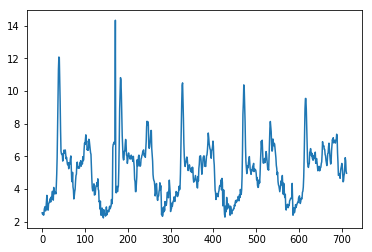

In [11]:
variation_set = np.array(variation_set)
pred_result_set = np.array(pred_result_set)
field_set = np.array(field_set)
final_rmse = np.sqrt(np.sum((pred_result_set - field_set) ** 2)/field_set.shape[0]/field_set.shape[1])
print(final_rmse)

plt.plot(loss_set)
# plt.plot(mf_loss_set)
plt.show

5.663953504473616


<function matplotlib.pyplot.show(*args, **kw)>

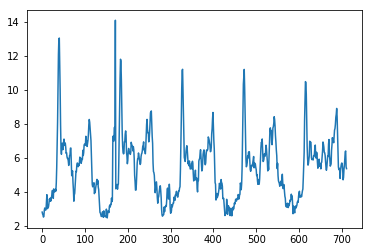

In [64]:
variation_set = np.array(variation_set)
hisresult = np.array(hisresult)
field_set = np.array(field_set)
final_rmse = np.sqrt(np.sum((hisresult - field_set) ** 2)/field_set.shape[0]/field_set.shape[1])
print(final_rmse)

plt.plot(loss_set)
# plt.plot(mf_loss_set)
plt.show

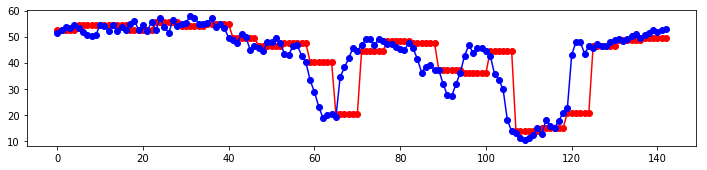

In [12]:
# process prediction from history
hisresult = np.array(hisresult)
i=0
road=1
speed_his=np.zeros(hisresult.shape[0])
speed_field=np.zeros(hisresult.shape[0])
while i<hisresult.shape[0]-pred_horizon:
    speed_his[i:i+pred_horizon]=hisresult[i,road*pred_horizon:(road+1)*pred_horizon]
    speed_field[i:i+pred_horizon]=field_set[i,road*pred_horizon:(road+1)*pred_horizon]
    i+=pred_horizon

plt.figure(figsize = (12, 2.5))
plt.plot(speed_his[1:144], 'r-o', speed_field[1:144], 'b-o')
# plt.plot(pred_result_set[road, :]/field[road, :], 'b')
plt.show()

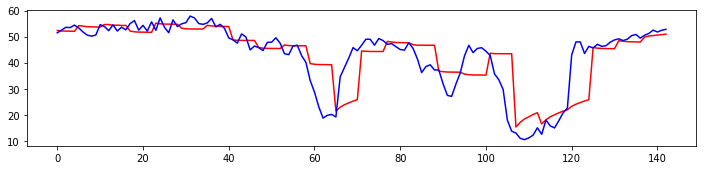

In [13]:
# process prediction from model
pred_result_set = np.array(pred_result_set)
i=0
road=1
speed_pred=np.zeros(pred_result_set.shape[0])
while i<pred_result_set.shape[0]-pred_horizon:
    speed_pred[i:i+pred_horizon]=pred_result_set[i,road*pred_horizon:(road+1)*pred_horizon]
    i+=pred_horizon

plt.figure(figsize = (12, 2.5))
plt.plot(speed_pred[1:144 ], 'r', speed_field[1:144], 'b')
# plt.plot(pred_result_set[road, :]/field[road, :], 'b')
plt.show()

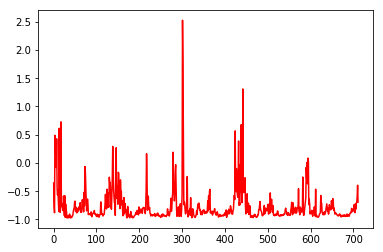

In [17]:
plt.plot(variation_set[:,1], 'r')
# plt.plot(pred_result_set[road, :]/field[road, :], 'b')
plt.show()

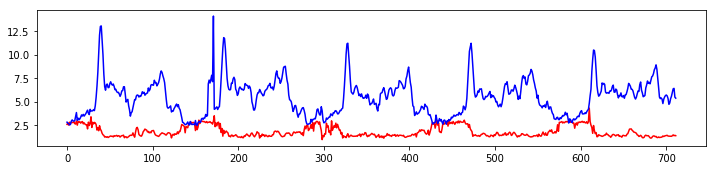

In [109]:
max_variation=[]
for i in range(variation_set.shape[0]):
    max_variation.append(max(abs(variation_set[i])))
    
plt.figure(figsize = (12, 2.5))
plt.plot(max_variation, 'r', loss_set, 'b')
# plt.plot(pred_result_set[road, :]/field[road, :], 'b')
plt.show()


In [40]:
field_predict_set[0].shape

(1284,)

In [103]:
x_batch, y_batch, lastspeed_batch = generateBatch(trainset,train_field_predict_set,lastspeedset=lastspeedset[0:end],batchsize=2, epoch=ep)

field_loss_,pred_result,lastspeed,variation,history = sess.run([model.loss, model.predict,model.lastspeed,model.varaiation,model.history ],
                                       feed_dict={model.bottom: x_batch, model.target: y_batch,model.lastspeed:lastspeed_batch})
        

In [118]:
max(variation[1])

1.1188651

In [108]:
history[0][1:18]

array([15.691, 15.691, 15.691, 15.691, 15.691,  5.816,  5.816,  5.816,
        5.816,  5.816,  5.816,  9.515,  9.515,  9.515,  9.515,  9.515,
        9.515], dtype=float32)

In [111]:
lastspeed_batch[0]

[15.691,
 5.816,
 9.515,
 15.902,
 29.535,
 25.567,
 26.386,
 15.307,
 12.319,
 13.364,
 41.579,
 9.766,
 10.055,
 31.388,
 36.487,
 24.552,
 17.299,
 12.275,
 36.932,
 38.216,
 9.71,
 23.094,
 37.802,
 18.362,
 25.921,
 24.972,
 15.318,
 40.706,
 30.062,
 17.094,
 35.777,
 5.001,
 25.35,
 9.89,
 34.068,
 27.289,
 25.438,
 5.413,
 14.396,
 33.996,
 20.094,
 24.7,
 20.7,
 14.091,
 24.352,
 17.929,
 12.454,
 38.50549335346337,
 33.292,
 40.515,
 43.43,
 22.055,
 16.71,
 17.025,
 38.50549335346337,
 17.125,
 20.186,
 13.908,
 11.994,
 21.728,
 9.134,
 13.958,
 12.4,
 38.292,
 34.31,
 16.673,
 27.134,
 9.996,
 11.937,
 30.875,
 29.035,
 19.405,
 22.243,
 36.182,
 3.506,
 20.71,
 25.399,
 28.541,
 21.446,
 10.75,
 32.063,
 19.947,
 25.632,
 22.967,
 9.864,
 18.308,
 20.692,
 10.529,
 39.712,
 27.703,
 21.979,
 20.297,
 17.307,
 7.323,
 10.593,
 42.373,
 35.357,
 38.069,
 20.823,
 14.246,
 7.525,
 34.818,
 21.376,
 8.363,
 16.279,
 8.193,
 15.28,
 16.01,
 20.883,
 20.36,
 11.871,
 30.839,
 9